In [1]:
import sys
sys.path.insert(0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')

import sys
sys.path.insert(0, '/home/563/esh563/TINT')

# Core
import datetime
import os
import glob
import tempfile
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
# import tint.animate
# from tint.visualisation import animate

import CPOL_func as cf
import classification as cl
import caine_func as caf
import analysis

# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport classification
%aimport tint.visualisation.figures
%aimport tint.visualisation.animate
%aimport tint.visualisation.horizontal_helpers
%aimport tint.visualisation.vertical_helpers
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport tint.matching
%aimport tint.rain
%aimport tint.cells
%aimport tint.tracks_helpers
%aimport tint.process_ERA5
%aimport tint.process_WRF

%pdb

base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/graphml.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (np.int, "int"), (np.int8, "int"),
/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/networkx/readwrite/gexf.py:220: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to us

Automatic pdb calling has been turned ON


In [2]:
path = save_dir + 'radar_63/63_2020_10.pkl'
with open(path, 'rb') as f:
    tracks_obj = pickle.load(f)

In [21]:
tracks_dir = [
    'base', 'lower_conv_level', 'higher_conv_level', 'two_levels',
    'four_levels', 'no_steiner', 'lower_ref_thresh', 'combined']

years = sorted(list(set(range(1998, 2016)) - {2007, 2008, 2000}))

for d in tracks_dir:
    for year in years:
        path = save_dir + '{}/{}1001_{}0501.pkl'.format(
            d, year, year+1)
        with open(path, 'rb') as f:
            tracks_obj = pickle.load(f)
            
        print('Fixing')
        tracks_obj = cl.redo_exclusions(tracks_obj)
        
        with open(path, 'wb') as f:
            pickle.dump(tracks_obj, f)

Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calculating system tracks.
Fixing
Calcula

In [22]:
conv_area_radar = []
strat_area_radar = []
times_radar = []

for radar in [63, 42, 77]:
    for year in [2020, 2021]:
        print('Radar {}, year {}.'.format(radar, year))
        years_months = [
            [year, 10], [year, 11], [year, 12],
            [year+1, 1], [year+1, 2], [year+1, 3],
            [year+1, 4]]
        for year_month in years_months:
            path = save_dir + 'radar_{}/{}_{}_{:02}.pkl'.format(
                radar, radar, year_month[0], year_month[1])
            with open(path, 'rb') as f:
                tracks_obj = pickle.load(f)

            tracks_obj = tint.objects.get_exclusion_categories(tracks_obj)
            print('Fixing.')
            with open(path, 'wb') as f:
                pickle.dump(tracks_obj, f)
                
                
conv_area_ACCESS = []
strat_area_ACCESS = []
times_ACCESS = []

Radar 63, year 2020.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Radar 63, year 2021.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Radar 42, year 2020.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Radar 42, year 2021.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Radar 77, year 2020.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Radar 77, year 2021.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.
Fixing.


In [23]:
for radar in [63, 42, 77]:
    for year in [2020, 2021]:
        print('Radar {}, year {}.'.format(radar, year))
        path = save_dir + 'ACCESS_{}/{}1001_{}0501.pkl'.format(
            radar, year, year+1)
        with open(path, 'rb') as f:
            tracks_obj = pickle.load(f)

        tracks_obj = tint.objects.get_exclusion_categories(tracks_obj)
        print('Fixing.')
        with open(path, 'wb') as f:
            pickle.dump(tracks_obj, f)

Radar 63, year 2020.
Fixing.
Radar 63, year 2021.
Fixing.
Radar 42, year 2020.
Fixing.
Radar 42, year 2021.
Fixing.
Radar 77, year 2020.
Fixing.
Radar 77, year 2021.
Fixing.


# Generate Figures

In [164]:
def get_boring_radar_stats(exclusions=None, regime=None, pope_dir=None):
    
    if pope_dir is None:
        pope_dir = '/home/student.unimelb.edu.au/shorte1/Documents/CPOL_analysis/'

    conv_area = []
    strat_area = []
    times = []

    count = 0
    system_count = 0
    
    if exclusions is None:        
        exclusions = [
            'small_area', 'large_area', 'intersect_border',
            'intersect_border_convective', 'duration_cond',
            'small_velocity', 'small_offset']

    for radar in [63, 42, 77]:
        for year in [2020, 2021]:
            print('Radar {}, year {}.'.format(radar, year))
            years_months = [
                [year, 10], [year, 11], [year, 12],
                [year+1, 1], [year+1, 2], [year+1, 3],
                [year+1, 4]]
            for year_month in years_months:
                path = save_dir + 'radar_{}/{}_{}_{:02}.pkl'.format(
                    radar, radar, year_month[0], year_month[1])
                with open(path, 'rb') as f:
                    tracks_obj = pickle.load(f)
                    
                tracks_obj = cl.redo_exclusions(tracks_obj)
                tracks_obj = cl.add_monsoon_regime(
                    tracks_obj, base_dir=pope_dir, fake_pope=True)

                excluded = tracks_obj.exclusions[exclusions]
                amb = 'Ambiguous (On Quadrant Boundary)'
                excluded = np.any(excluded, 1)
                included = np.logical_not(excluded)
                
                if regime is None:
                    cond = (included==True)
                else:
                    cond = np.logical_and(
                        tracks_obj.tracks_class['pope_regime']==regime,
                        included==True)

                sub_classes = tracks_obj.tracks_class.where(cond).dropna()

                inds_all = sub_classes.index.values
                sub_tracks_all = tracks_obj.tracks.loc[inds_all]
                try:
                    sub_tracks_conv = sub_tracks_all.xs(0, level='level')
                    sub_tracks_strat = sub_tracks_all.xs(1, level='level')
                    conv_area += list(sub_tracks_conv['proj_area'].values)
                    strat_area += list(sub_tracks_strat['proj_area'].values)
                    times += list(
                        sub_tracks_conv.reset_index()['time'].values)
                    count += len(sub_tracks_conv)
                    uids = set([ind[2] for ind in inds_all])
                    system_count += len(uids)

                except KeyError:
                    print('No included observations.')
                    
    return conv_area, strat_area, times, count, system_count

In [165]:
def get_boring_ACCESS_stats(exclusions=None, regime=None, pope_dir=None):

    if pope_dir is None:
        pope_dir = '/home/student.unimelb.edu.au/shorte1/Documents/CPOL_analysis/'

    conv_area = []
    strat_area = []
    times = []

    count = 0
    system_count = 0
    
    if exclusions is None:        
        exclusions = [
            'small_area', 'large_area', 'intersect_border',
            'intersect_border_convective', 'duration_cond',
            'small_velocity', 'small_offset']

    for radar in [63, 42, 77]:
        for year in [2020, 2021]:
            print('Radar {}, year {}.'.format(radar, year))
            path = save_dir + 'ACCESS_{}/{}1001_{}0501.pkl'.format(
                radar, year, year+1)
            with open(path, 'rb') as f:
                tracks_obj = pickle.load(f)

            tracks_obj = cl.redo_exclusions(tracks_obj)
            tracks_obj = cl.add_monsoon_regime(
                tracks_obj, base_dir=pope_dir, fake_pope=True)

            excluded = tracks_obj.exclusions[exclusions]
            amb = 'Ambiguous (On Quadrant Boundary)'
            excluded = np.any(excluded, 1)
            included = np.logical_not(excluded)

            if regime is None:
                cond = (included==True)
            else:
                cond = np.logical_and(
                    tracks_obj.tracks_class['pope_regime']==regime,
                    included==True)

            sub_classes = tracks_obj.tracks_class.where(cond).dropna()

            inds_all = sub_classes.index.values
            sub_tracks_all = tracks_obj.tracks.loc[inds_all]
            try:
                sub_tracks_conv = sub_tracks_all.xs(0, level='level')
                sub_tracks_strat = sub_tracks_all.xs(1, level='level')
                conv_area += list(sub_tracks_conv['proj_area'].values)
                strat_area += list(sub_tracks_strat['proj_area'].values)
                times += list(
                    sub_tracks_conv.reset_index()['time'].values)
                count += len(sub_tracks_conv)
                uids = set([ind[2] for ind in inds_all])
                system_count += len(uids)

            except KeyError:
                print('No included observations.')
    return conv_area, strat_area, times, count, system_count

In [166]:
all_obs_radar = get_boring_radar_stats(['simple_duration_cond'], None)
QC_obs_radar = get_boring_radar_stats(None, None)

all_obs_weak_radar = get_boring_radar_stats(['simple_duration_cond'], 1)
QC_obs_weak_radar = get_boring_radar_stats(None, 1)

all_obs_active_radar = get_boring_radar_stats(['simple_duration_cond'], 2)
QC_obs_active_radar = get_boring_radar_stats(None, 2)

Radar 63, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
Calc

No included observations.
Calculating system tracks.
No included observations.
Radar 77, year 2020.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Radar 77, year 2021.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.
Calculating system tracks.
Calculating system tracks.
Calculating system tracks.
No included observations.
Calculating system tracks.
No included observations.


In [167]:
all_obs_ACCESS = get_boring_ACCESS_stats(['simple_duration_cond'], None)
QC_obs_ACCESS = get_boring_ACCESS_stats(None, None)

all_obs_weak_ACCESS = get_boring_ACCESS_stats(['simple_duration_cond'], 1)

QC_obs_weak_ACCESS = get_boring_ACCESS_stats(None, 1)

all_obs_active_ACCESS = get_boring_ACCESS_stats(['simple_duration_cond'], 2)
QC_obs_active_ACCESS = get_boring_ACCESS_stats(None, 2)

Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 42, year 2020.
Calculating system tracks.
Radar 42, year 2021.
Calculating system tracks.
Radar 77, year 2020.
Calculating system tracks.
Radar 77, year 2021.
Calculating system tracks.
Radar 63, year 2020.
Calculating system tracks.
Radar 63, year 2021.
Calculating system tracks.
Radar 42, year 2020.
Calculating system 

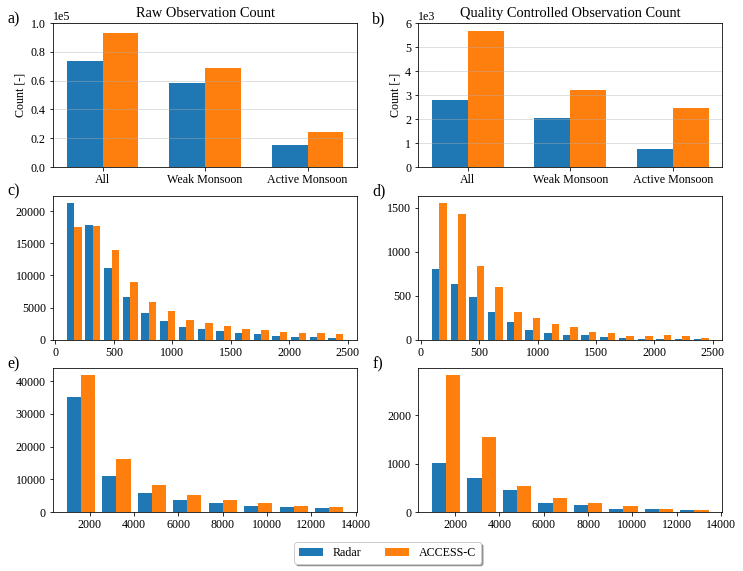

In [168]:
fig, ax = plt.subplots(3, 2, figsize=(12,9))
cl.init_fonts()

labels = ['All', 'Weak Monsoon', 'Active Monsoon']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

radar = [all_obs_radar[3], all_obs_weak_radar[3], all_obs_active_radar[3]]
ACCESS = [
    all_obs_ACCESS[3], all_obs_weak_ACCESS[3], all_obs_active_ACCESS[3]]

QC_radar = [QC_obs_radar[3], QC_obs_weak_radar[3], QC_obs_active_radar[3]]
QC_ACCESS = [
    QC_obs_ACCESS[3], QC_obs_weak_ACCESS[3], QC_obs_active_ACCESS[3]]

rects1 = ax.flatten()[0].bar(x - width/2, radar, width, label='Radar')
rects2 = ax.flatten()[0].bar(x + width/2, ACCESS, width, label='ACCESS-C')

rects3 = ax.flatten()[1].bar(x - width/2, QC_radar, width, label='Radar')
rects4 = ax.flatten()[1].bar(x + width/2, QC_ACCESS, width, label='ACCESS-C')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.flatten()[0].set_ylabel('Count [-]')
ax.flatten()[0].set_title('Raw Observation Count')
ax.flatten()[0].set_xticks(x)
ax.flatten()[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.flatten()[0].set_yticks(np.arange(0, 120000, 20000))
ax.flatten()[0].set_xticklabels(labels)
ax.flatten()[0].grid(which='major', alpha=0.5, axis='y')

ax.flatten()[1].set_ylabel('Count [-]')
ax.flatten()[1].set_title('Quality Controlled Observation Count')
ax.flatten()[1].set_xticks(x)
ax.flatten()[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.flatten()[1].set_yticks(np.arange(0, 7000, 1000))

ax.flatten()[1].set_xticklabels(labels)
ax.flatten()[1].grid(which='major', alpha=0.5, axis='y')

ax.flatten()[2].hist(
    [all_obs_radar[0], all_obs_ACCESS[0]], 
    bins=np.arange(80, 2500, 160), label=['Radar', 'ACCESS-C'])

ax.flatten()[3].hist(
    [QC_obs_radar[0], QC_obs_ACCESS[0]], 
    bins=np.arange(80, 2500, 160), label=['Radar', 'ACCESS-C'])

ax.flatten()[4].hist(
    [all_obs_radar[1], all_obs_ACCESS[1]], 
    bins=np.arange(800, 15000, 1600), label=['Radar', 'ACCESS-C'])

ax.flatten()[5].hist(
    [QC_obs_radar[1], QC_obs_ACCESS[1]], 
    bins=np.arange(800, 15000, 1600), label=['Radar', 'ACCESS-C'])

ax.flatten()[4].legend(
    loc='lower center', bbox_to_anchor=(1.1, -0.4),
    ncol=2, fancybox=True, shadow=True)

cl.make_subplot_labels(ax.flatten(), x_shift=-.15)
# plt.subplots_adjust(wspace=.5)

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

# fig.tight_layout()

plt.show()

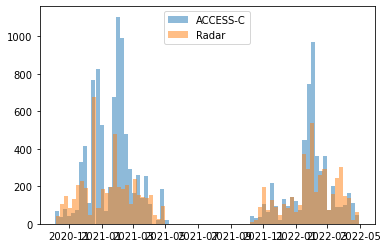

In [156]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.hist(times_ACCESS, bins=75, alpha=0.5, label='ACCESS-C')
ax.hist(times_radar, bins=75, alpha=0.5, label='Radar')
plt.legend()

In [132]:
path = save_dir + 'ACCESS_63/20211001_20220501.pkl'
with open(path, 'rb') as f:
    tracks_obj_ACCESS = pickle.load(f)
    
path = save_dir + 'radar_63/63_2022_01.pkl'
with open(path, 'rb') as f:
    tracks_obj_radar = pickle.load(f)

In [133]:
tracks_obj_ACCESS.tracks = tracks_obj_ACCESS.tracks.loc[:,slice(np.datetime64('2022-01-01'), np.datetime64('2022-02-01')),:,:]

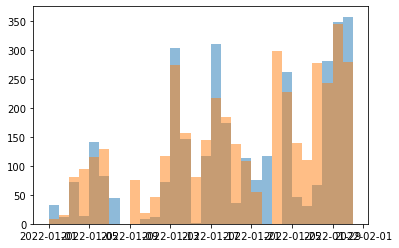

In [135]:
bins = np.arange(np.datetime64('2022-01-01'), np.datetime64('2022-02-01'), np.timedelta64(1, 'D'))

h1 = plt.hist(list(tracks_obj_ACCESS.tracks.xs(0, level='level').reset_index()['time'].values), alpha=0.5, bins=bins)
h1 = plt.hist(list(tracks_obj_radar.tracks.xs(0, level='level').reset_index()['time'].values), alpha=0.5, bins=bins)

In [177]:
np.all(tracks_obj.exclusions['simple_duration_cond'])

False